**<center><h1>Docling for Data Extraction: Testing Its Performance in Table Extraction</h1></center>**

Over the past few months, I have experimented with various data extraction solutions, particularly focusing on table extraction. While detecting tables is relatively straightforward, I often encountered challenges in accurately recognizing the content within them, especially when it comes to handling the diverse and complex structures of the tables. The issues were mainly related to maintaining the correct structure and ensuring accurate text recognition. In this notebook, I will test Docling for document parsing, with a particular emphasis on table extraction, to evaluate its performance and determine whether it can consistently extract tables correctly.

### **Table of Contents**

* [Install Libraries](#chapter1)
* [Import Libraries](#chapter2)
* [Extracting Text and Tables Using Docling](#chapter3)
    * [Example n°1](#section_1)
    * [Example n°2](#section_2)
    * [Example n°3](#section_3)
    * [Example n°4](#section_4)
    * [Example n°5](#section_5)
    * [Example n°6](#section_6)
    * [Example n°7](#section_7)
* [Conclusion](#chapter4)

## **1. Install Libraries**  <a class="anchor"  id="chapter1"></a>

In [1]:
%%capture
#! pip install -U ipywidgets
! pip install docling
! pip install pdf2image
! apt-get update && apt-get install -y poppler-utils

## **2. Import Libraries**   <a class="anchor"  id="chapter2"></a>

In [2]:
import logging
import time
from pathlib import Path
import pandas as pd
from pdf2image import convert_from_path
import matplotlib.pyplot as plt
from PIL import Image
import os
from docling.datamodel.base_models import InputFormat
from docling.document_converter import DocumentConverter, PdfFormatOption
from docling.datamodel.pipeline_options import PdfPipelineOptions, TableFormerMode

In [3]:
_log = logging.getLogger(__name__)

## **3. Extracting Text and Tables Using Docling**  <a class="anchor"  id="chapter3"></a>

First, let's define a function that displays the provided input in a form of an image.

In [4]:
def display_file(file_path):
    """
    Display a PDF file or an image file.

    Args:
        file_path (str): Path to the PDF or image file.
    """
    # Check file extension to determine the type
    file_extension = os.path.splitext(file_path)[1].lower()
    
    if file_extension == '.pdf':
        # Convert and display PDF pages as images
        images = convert_from_path(file_path)
        for i, image in enumerate(images):
            plt.figure(figsize=(16, 12))
            plt.imshow(image)
            plt.axis('off')  # Hide axis for a cleaner look
            plt.show()
    elif file_extension in ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']:
        # Open and display the image file
        image = Image.open(file_path)
        plt.figure(figsize=(16, 12))
        plt.imshow(image)
        plt.axis('off')  # Hide axis for a cleaner look
        plt.show()
    else:
        raise ValueError("Unsupported file type. Please provide a PDF or image file.")

Also let's define another function for data extraction with Docling.

In [8]:
def extract_data_with_docling(input_data_path):
    """
    Extracts data from a PDF or image file using the Docling library. 
    Displays the document's content as markdown and exports any tables found in the document to CSV files.

    Args:
        input_data_path (str): The path to the input file (PDF or image).
    """
    # Initialize pipeline options with table structure analysis enabled
    pipeline_options = PdfPipelineOptions(do_table_structure=True)
    pipeline_options.table_structure_options.mode = TableFormerMode.ACCURATE  # use more accurate TableFormer model

    # Create a document converter with specified format options
    doc_converter = DocumentConverter(
        allowed_formats=[
                InputFormat.PDF,
                InputFormat.IMAGE,
            ],  # whitelist formats, non-matching files are ignored.
        format_options={
            InputFormat.PDF: PdfFormatOption(pipeline_options=pipeline_options)
        }
    )
    result = doc_converter.convert(input_data_path)
    print(result.document.export_to_markdown())

    doc_filename = result.input.file.stem
    # Loop through each table detected in the document and Export it
    for table_ix, table in enumerate(result.document.tables):
        table_df: pd.DataFrame = table.export_to_dataframe()
        print(f"## Table {table_ix}")
        #print(table_df.to_markdown())

        # Save the table as csv
        element_csv_filename = f"{doc_filename}-table-{table_ix+1}.csv"
        _log.info(f"Saving CSV table to {element_csv_filename}")
        table_df.to_csv(element_csv_filename)

Let's dive into some examples, using both PDF files and table images to evaluate Docling's performance.

#### **Example n°1**  <a class="anchor"  id="section_1"></a>

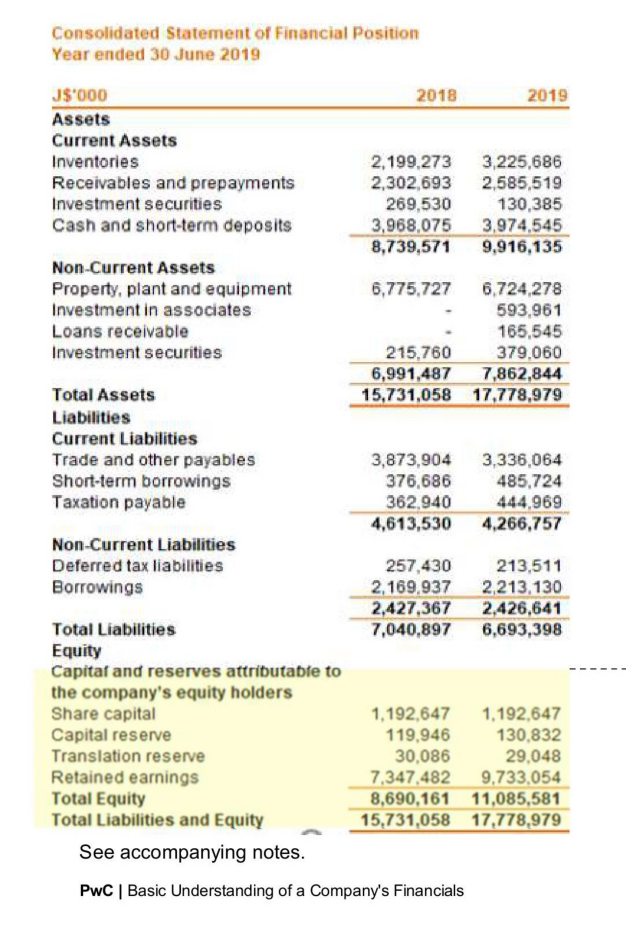

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

## Consolulaler Slolemenl oi Flnancini Posiion Yedi einled J0 une 2019

| J$'0oo                               | 2018       | 2012       |
|--------------------------------------|------------|------------|
| Assels                               |            |            |
| Currenl Assels                       |            |            |
| Invenlorles                          | 2,199,273  | 3,225,686  |
| Receivables and prepayments          | 2,902,693  | 2,585.519  |
| Invesiment securiles                 | 269,530    | 130,385    |
| cash and sh@rt-lø M deposlls         | 3,968,075  | 3,974,545  |
|                                      | 8,739,571  | 9,916,135  |
| Non-Current Assets                   |            |            |
| Property plant and equipment         | 6,775,727  | 6,724 278  |
| InvesimentIn assocates               |            | 693,961    |
| Loans recelvable                     |            | 165,545    |
| Invesient securlies                  | 215.760    | 379

In [12]:
display_file("/kaggle/input/different-tables-images-testing/table_1.jpg")
extract_data_with_docling("/kaggle/input/different-tables-images-testing/table_1.jpg")

As seen above, it successfully extracts the table, although there are some incorrect characters in the elements of the first column.

In [15]:
df = pd.read_csv("/kaggle/working/table_1-table-1.csv")
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df

,J$'0oo,2018,2012
0,Assels,NaN,NaN
1,Currenl Assels,NaN,NaN
2,Invenlorles,"2,199,273","3,225,686"
3,Receivables and prepayments,"2,902,693","2,585.519"
4,Invesiment securiles,"269,530","130,385"
5,cash and sh@rt-lø M deposlls,"3,968,075","3,974,545"
6,NaN,"8,739,571","9,916,135"
7,Non-Current Assets,NaN,NaN
8,Property plant and equipment,"6,775,727","6,724 278"
9,InvesimentIn assocates,NaN,"693,961"


#### **Example n°2**  <a class="anchor"  id="section_2"></a>

Now let's test it with a bigger table.

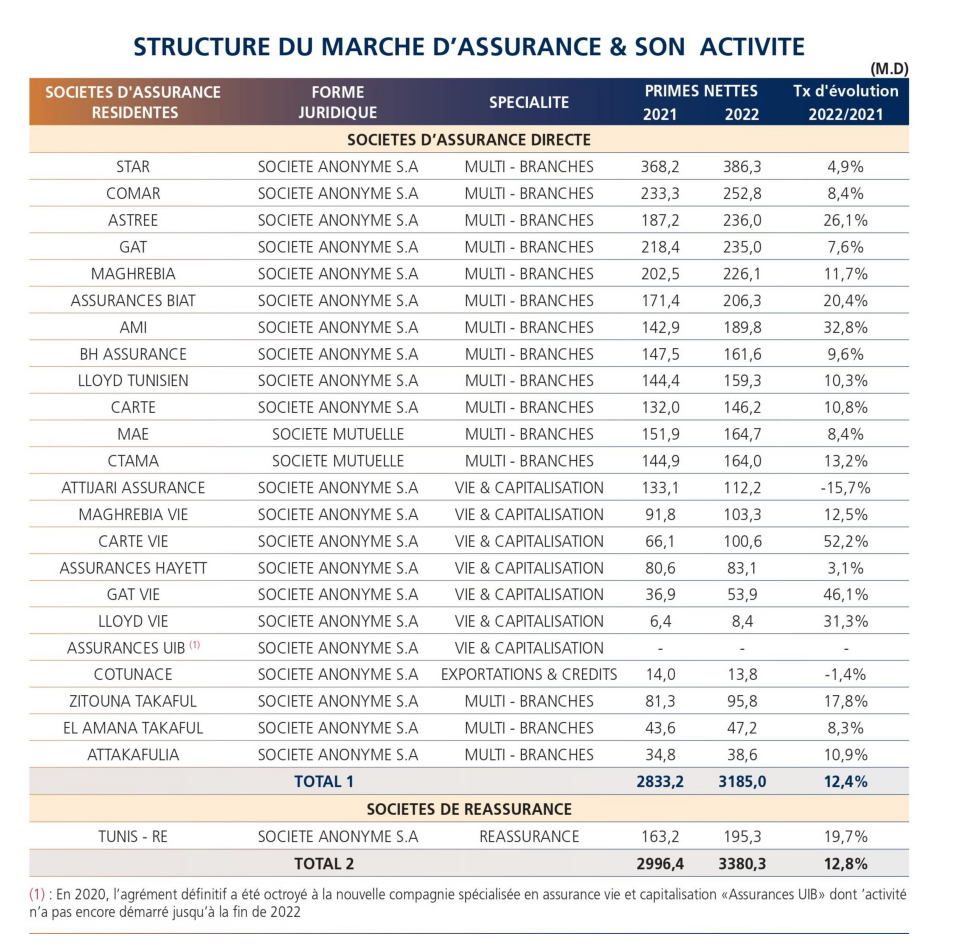

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

## STRUCTURE DU MARCHE D'ASSURANCE & SON ACTIVITE

| SOCIETES D'ASSURANCE RESIDENTES   | FORME JURIDIQUE              | SPECIALITE                   | PRIMES NETTES 2021 2022      | PRIMES NETTES 2021 2022      | (M.D) Tx d'évolution 2022/2021   |
|-----------------------------------|------------------------------|------------------------------|------------------------------|------------------------------|----------------------------------|
| SOCIETES D'ASSURANCE DIRECTE      | SOCIETES D'ASSURANCE DIRECTE | SOCIETES D'ASSURANCE DIRECTE | SOCIETES D'ASSURANCE DIRECTE | SOCIETES D'ASSURANCE DIRECTE | SOCIETES D'ASSURANCE DIRECTE     |
| STAR                              | SOCIETE ANONYME S.A          | MULTI BRANCHES               | 368,2                        | 386,3                        | 4,9%                             |
| COMAR                             | SOCIETE ANONYME S.A          | MULTI BRANCHES               | 233,3                        | 252,8                        |

In [16]:
display_file("/kaggle/input/different-tables-images-testing/other_table_big.jpg")
extract_data_with_docling("/kaggle/input/different-tables-images-testing/other_table_big.jpg")

as you see in the dataframe below, Docling managed to recognize the table's structure and extract the words and numbers correctly.

In [18]:
df = pd.read_csv("/kaggle/working/other_table_big-table-1.csv")
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df

,SOCIETES D'ASSURANCE RESIDENTES,FORME JURIDIQUE,SPECIALITE,PRIMES NETTES 2021 2022,PRIMES NETTES 2021 2022.1,(M.D) Tx d'évolution 2022/2021
0,SOCIETES D'ASSURANCE DIRECTE,SOCIETES D'ASSURANCE DIRECTE,SOCIETES D'ASSURANCE DIRECTE,SOCIETES D'ASSURANCE DIRECTE,SOCIETES D'ASSURANCE DIRECTE,SOCIETES D'ASSURANCE DIRECTE
1,STAR,SOCIETE ANONYME S.A,MULTI BRANCHES,"368,2","386,3","4,9%"
2,COMAR,SOCIETE ANONYME S.A,MULTI BRANCHES,"233,3","252,8","8,4%"
3,ASTREE,SOCIETE ANONYME S.A,MULTI BRANCHES,"187,2","236,0","26,1 %"
4,GAT,SOCIETE ANONYME S.A,MULTI BRANCHES,"218,4","235,0","7,6%"
5,MAGHREBIA,SOCIETE ANONYME S.A,MULTI BRANCHES,"202,5","226,1","11,7%"
6,ASSURANCES BIAT,SOCIETE ANONYME S.A,MULTI BRANCHES,"171,4","206,3","20,4%"
7,AMI,SOCIETE ANONYME S.A,MULTI BRANCHES,"142,9","189,8","32,8%"
8,BH ASSURANCE,SOCIETE ANONYME S.A,MULTI BRANCHES,"147,5","161,6","9,6%"
9,LLOYD TUNISIEN,SOCIETE ANONYME S.A,MULTI BRANCHES,"144,4","159,3","10,3%"


#### **Example n°3**  <a class="anchor"  id="section_3"></a>

let's try it now with a table with more difficult structure.

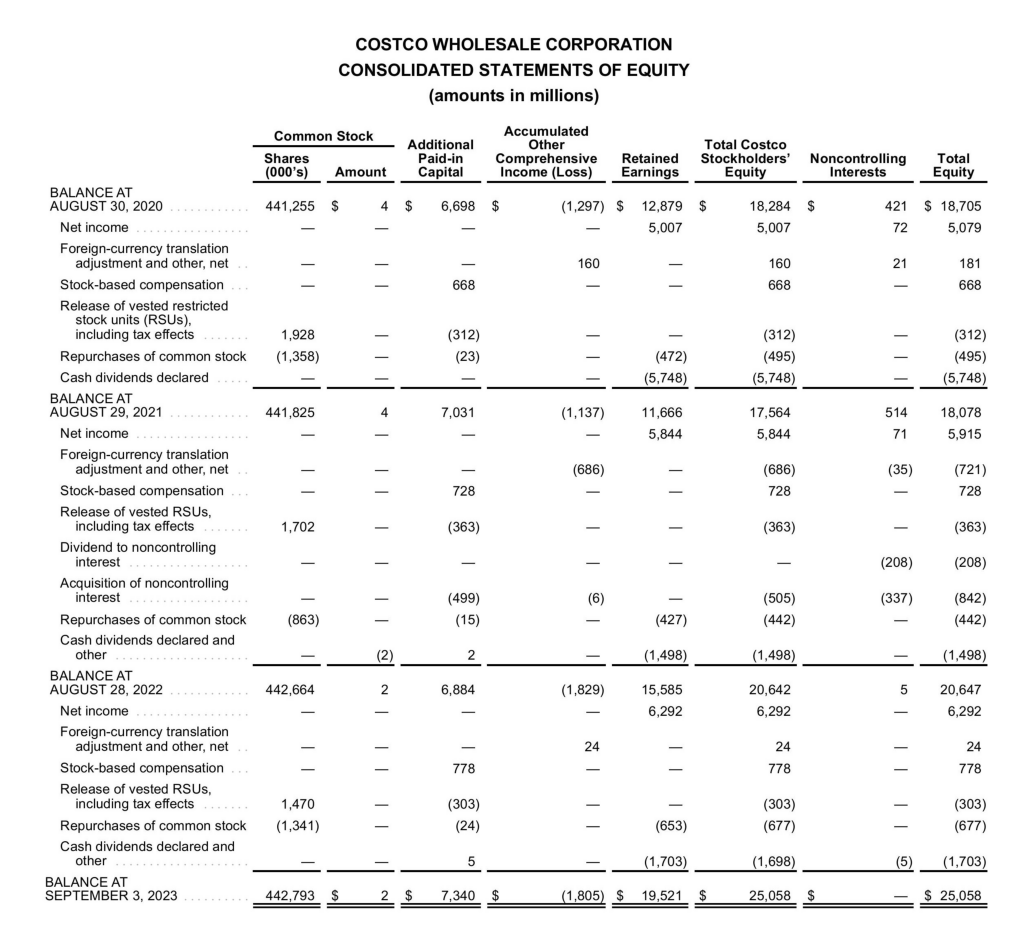

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

## COSTCO WHOLESALE CORPORATION

## CONSOLIDATED STATEMENTS OF EQUITY

(amounts in millions)

|                                                                       | Common Stock   | Common Stock   | Additional   | Accumulated Other   |          | Total Costco         |                |          |
|-----------------------------------------------------------------------|----------------|----------------|--------------|---------------------|----------|----------------------|----------------|----------|
|                                                                       | Shares         |                | Paid-in      | Comprehensive       | Retained |                      | Noncontrolling | Total    |
|                                                                       | (oo0's)        | Amount         | Capital      | Income (Loss)       | Earnings | Stockholders' Equity | Interests      | Equity   |
| BALANCE AT AUGUST 30, 2020                                            | 441,

In [17]:
display_file("/kaggle/input/different-tables-images-testing/table_3.jpg")
extract_data_with_docling("/kaggle/input/different-tables-images-testing/table_3.jpg")

as you see below, even with an unusual table structure, it managed to extract it correctly.

In [22]:
df = pd.read_csv("/kaggle/working/table_3-table-1.csv")
df = df.loc[:, ~df.columns.str.contains('^Unnamed: 0')]
df

,Unnamed: 1,Common Stock.Shares.(oo0's),Common Stock..Amount,Additional.Paid-in.Capital,Accumulated Other.Comprehensive.Income (Loss),Retained.Earnings,Total Costco..Stockholders' Equity,Noncontrolling.Interests,Total.Equity
0,"BALANCE AT AUGUST 30, 2020","441,255",$ 4,"$ 6,698","$ (1,297)","$ 12,879","$ 18,284",$ 421,"$ 18,705"
1,Net income,NaN,NaN,NaN,NaN,"5,007","5,007",72,"5,079"
2,Foreign-currency translation adjustment and ot...,NaN,NaN,NaN,160,NaN,160,21,181
3,Stock-based compensation,NaN,NaN,668,NaN,NaN,668,NaN,668
4,Release of vested restricted stock units (RSUs...,"1,928",NaN,(312),NaN,NaN,(312),NaN,(312)
5,Repurchases of common stock,"(1,358)",NaN,(23),NaN,(472),(495),NaN,(495)
6,Cash dividends declared,NaN,NaN,NaN,NaN,"(5,748)","(5,748)",NaN,"(5,748)"
7,"BALANCE AT AUGUST 29, 2021","441,825",NaN,"7,031","(1,137)","11,666","17,564",514,"18,078"
8,Net income,NaN,NaN,NaN,NaN,"5,844","5,844",71,"5,915"
9,Foreign-currency translation adjustment and ot...,NaN,NaN,NaN,(686),NaN,(686),(35),(721)


Now let's try using pdf files that contain tables.

#### **Example n°4** <a class="anchor"  id="section_4"></a>

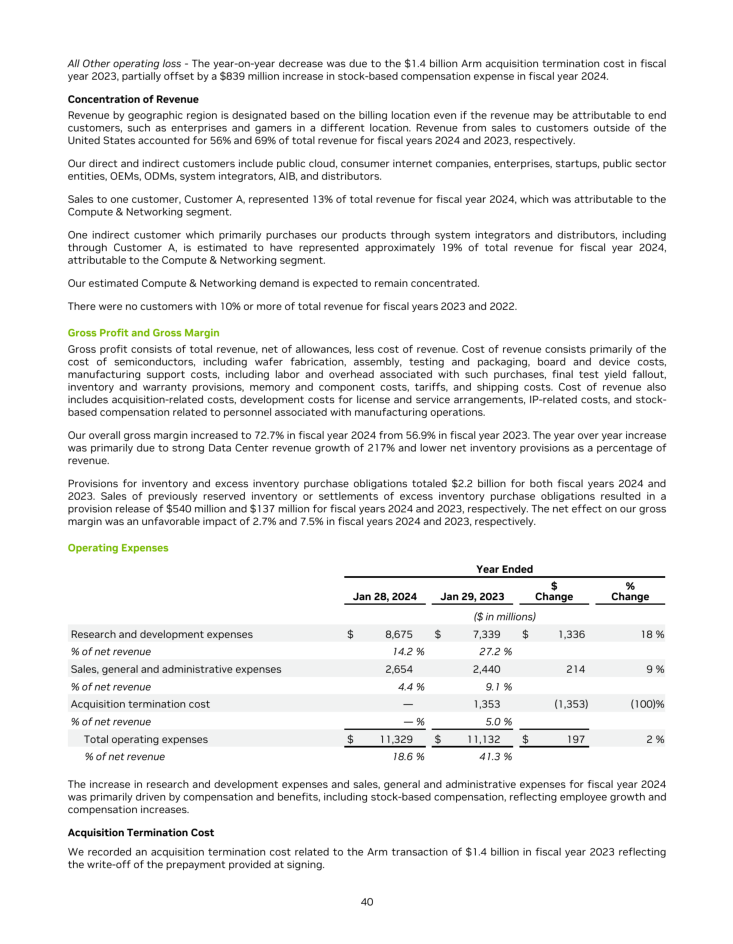

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

All Other operating loss - The year-on-year decrease was due to the $1.4 billion Arm acquisition termination cost in fiscal year 2023, partially offset by a $839 million increase in stock-based compensation expense in fiscal year 2024.

## Concentration of Revenue

Revenue by geographic region is designated based on the billing location even if the revenue may be attributable to end customers, such as enterprises and gamers in a different location. Revenue from sales to customers outside of the United States accounted for 56% and 69% of total revenue for fiscal years 2024 and 2023, respectively.

Our direct and indirect customers include public cloud, consumer internet companies, enterprises, startups, public sector entities, OEMs, ODMs, system integrators, AIB, and distributors.

Sales to one customer, Customer A, represented 13% of total revenue for fiscal year 2024, which was attributable to the Compute & Networking segment.

One indirect customer which primarily purchases our produ

In [23]:
display_file("/kaggle/input/nvidia-annual-report/NVIDIA_Report_Removed_Pages-1-16-10.pdf")
extract_data_with_docling("/kaggle/input/nvidia-annual-report/NVIDIA_Report_Removed_Pages-1-16-10.pdf")

In [24]:
df = pd.read_csv("/kaggle/working/NVIDIA_Report_Removed_Pages-1-16-10-table-1.csv")
df = df.loc[:, ~df.columns.str.contains('^Unnamed: 0')]
df

,Unnamed: 1,"Year Ended.Jan 28, 2024.($ in millions)","Year Ended.Jan 29, 2023.($ in millions)",Year Ended.$ Change.($ in millions),Year Ended.% Change.($ in millions)
0,Research and development expenses,"$ 8,675","$ 7,339","$ 1,336",18 %
1,% of net revenue,14.2 %,27.2 %,NaN,NaN
2,"Sales, general and administrative expenses","2,654","2,440",214,9 %
3,% of net revenue,4.4 %,9.1 %,NaN,NaN
4,Acquisition termination cost,-,"1,353","(1,353)",(100)%
5,% of net revenue,- %,5.0 %,NaN,NaN
6,Total operating expenses,"$ 11,329","$ 11,132",$ 197,2 %
7,% of net revenue,18.6 %,41.3 %,NaN,NaN


#### **Example n°5**  <a class="anchor"  id="section_5"></a>

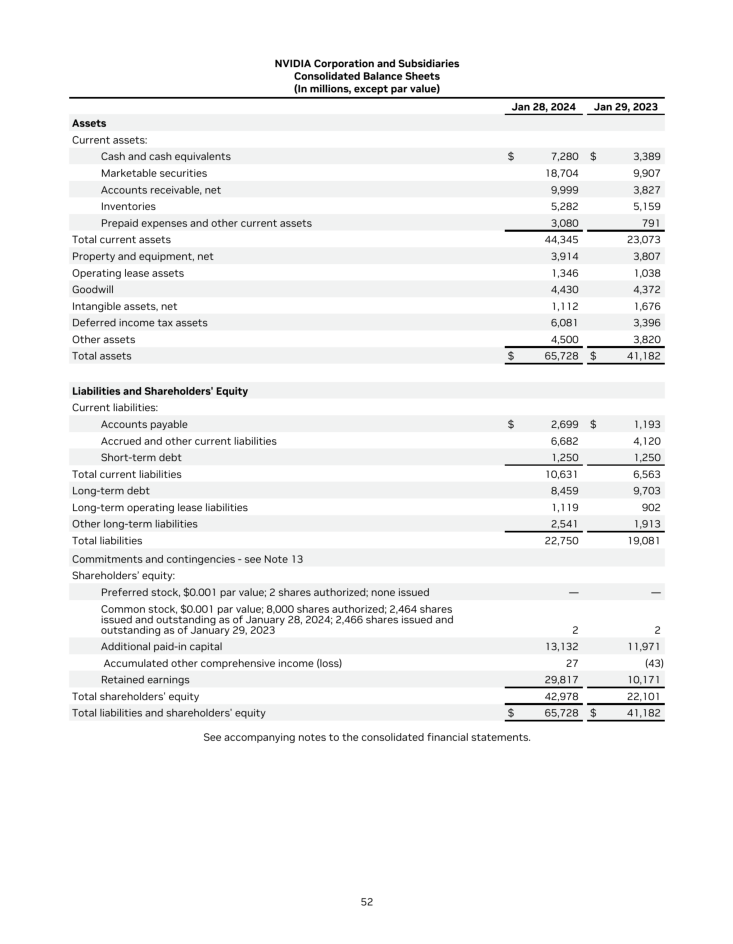

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

## NVIDIA Corporation and Subsidiaries

## Consolidated Balance Sheets

(In millions, except par value)

|                                                                                                                                                                                   | Jan 28, 2024   | Jan 29, 2023   |
|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|----------------|----------------|
| Assets                                                                                                                                                                            |                |                |
| Current assets:                                                                                                                                                                   |                |                |
| Cash and cash equivalents    

In [25]:
display_file("/kaggle/input/nvidia-annual-report/NVIDIA_Report_Removed_Pages-1-16-14.pdf")
extract_data_with_docling("/kaggle/input/nvidia-annual-report/NVIDIA_Report_Removed_Pages-1-16-14.pdf")

In [26]:
df = pd.read_csv("/kaggle/working/NVIDIA_Report_Removed_Pages-1-16-14-table-1.csv")
df = df.loc[:, ~df.columns.str.contains('^Unnamed: 0')]
df

,Unnamed: 1,"Jan 28, 2024","Jan 29, 2023"
0,Assets,NaN,NaN
1,Current assets:,NaN,NaN
2,Cash and cash equivalents,"$ 7,280","$ 3,389"
3,Marketable securities,"18,704","9,907"
4,"Accounts receivable, net","9,999","3,827"
5,Inventories,"5,282","5,159"
6,Prepaid expenses and other current assets,"3,080",791
7,Total current assets,"44,345","23,073"
8,"Property and equipment, net","3,914","3,807"
9,Operating lease assets,"1,346","1,038"


#### **Example n°6**  <a class="anchor"  id="section_6"></a>

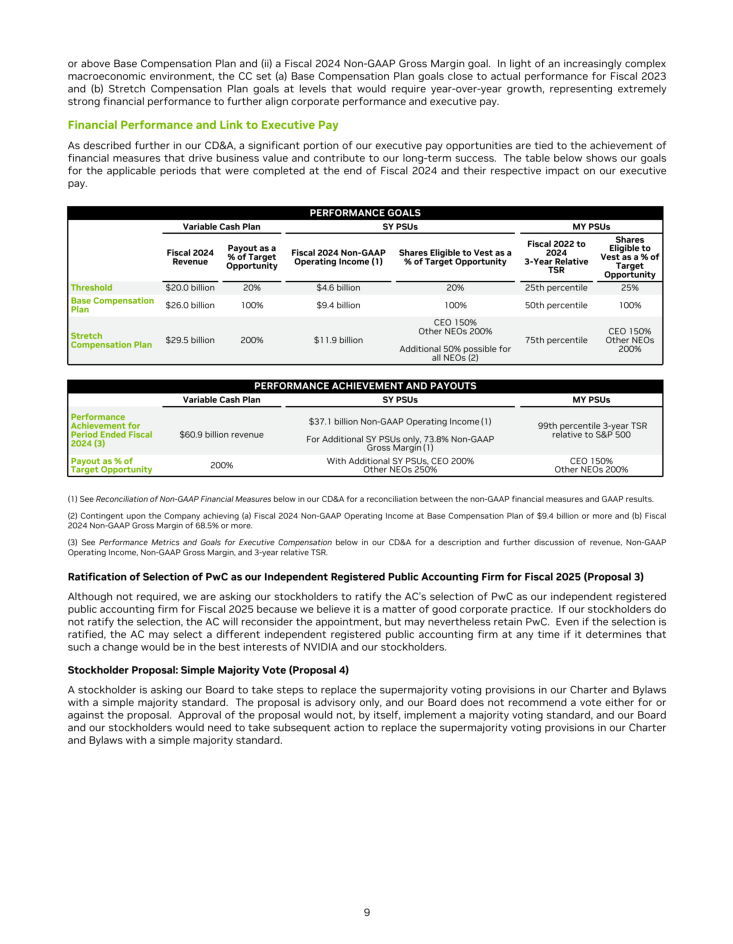

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

or above Base Compensation Plan and (ii) a Fiscal 2024 Non-GAAP Gross Margin goal. In light of an increasingly complex macroeconomic environment, the CC set (a) Base Compensation Plan goals close to actual performance for Fiscal 2023 and (b) Stretch Compensation Plan goals at levels that would require year-over-year growth, representing extremely strong financial performance to further align corporate performance and executive pay.

## Financial Performance and Link to Executive Pay

As described further in our CD&A, a significant portion of our executive pay opportunities are tied to the achievement of financial measures that drive business value and contribute to our long-term success. The table below shows our goals for the applicable periods that were completed at the end of Fiscal 2024 and their respective impact on our executive pay.

|                            | PERFORMANCE GOALS    | PERFORMANCE GOALS                     | PERFORMANCE GOALS                          | PERFORMA

In [27]:
display_file("/kaggle/input/nvidia-annual-report/NVIDIA_Report_Removed_Pages-1-16-2.pdf")
extract_data_with_docling("/kaggle/input/nvidia-annual-report/NVIDIA_Report_Removed_Pages-1-16-2.pdf")

In [29]:
df = pd.read_csv("/kaggle/working/NVIDIA_Report_Removed_Pages-1-16-2-table-1.csv")
df = df.loc[:, ~df.columns.str.contains('^Unnamed: 0')]
df

,Unnamed: 1,PERFORMANCE GOALS.Variable Cash Plan.Fiscal 2024 Revenue,PERFORMANCE GOALS.Variable Cash Plan.Payout as a % of Target Opportunity,PERFORMANCE GOALS.SY PSUs.Fiscal 2024 Non-GAAP Operating Income (1),PERFORMANCE GOALS.SY PSUs.Shares Eligible to Vest as a % of Target Opportunity,PERFORMANCE GOALS.MY PSUs.Fiscal 2022 to 2024 3-Year Relative TSR,PERFORMANCE GOALS.MY PSUs.Shares Eligible to Vest as a % of Target Opportunity
0,Threshold,$20.0 billion,20%,$4.6 billion,20%,25th percentile,25%
1,Base Compensation Plan,$26.0 billion,100%,$9.4 billion,100%,50th percentile,100%
2,Stretch Compensation Plan,$29.5 billion,200%,$11.9 billion,CEO 150% Other NEOs 200% Additional 50% possi...,75th percentile,CEO 150% Other NEOs 200%


In [30]:
df = pd.read_csv("/kaggle/working/NVIDIA_Report_Removed_Pages-1-16-2-table-2.csv")
df = df.loc[:, ~df.columns.str.contains('^Unnamed: 0')]
df

,0,1,2,3
0,PERFORMANCE ACHIEVEMENT AND PAYOUTS,PERFORMANCE ACHIEVEMENT AND PAYOUTS,PERFORMANCE ACHIEVEMENT AND PAYOUTS,PERFORMANCE ACHIEVEMENT AND PAYOUTS
1,NaN,Variable Cash Plan,SY PSUs,MY PSUs
2,Performance Achievement for Period Ended Fis...,$60.9 billion revenue,$37.1 billion Non-GAAP Operating Income(1) For...,99th percentile 3-year TSR relative to S&P 500
3,Payout as % of Target Opportunity,200%,"With Additional SY PSUs, CEO 200% Other NEOs 250%",CEO 150% Other NEOs 200%


#### **Example n°7**  <a class="anchor"  id="section_7"></a>

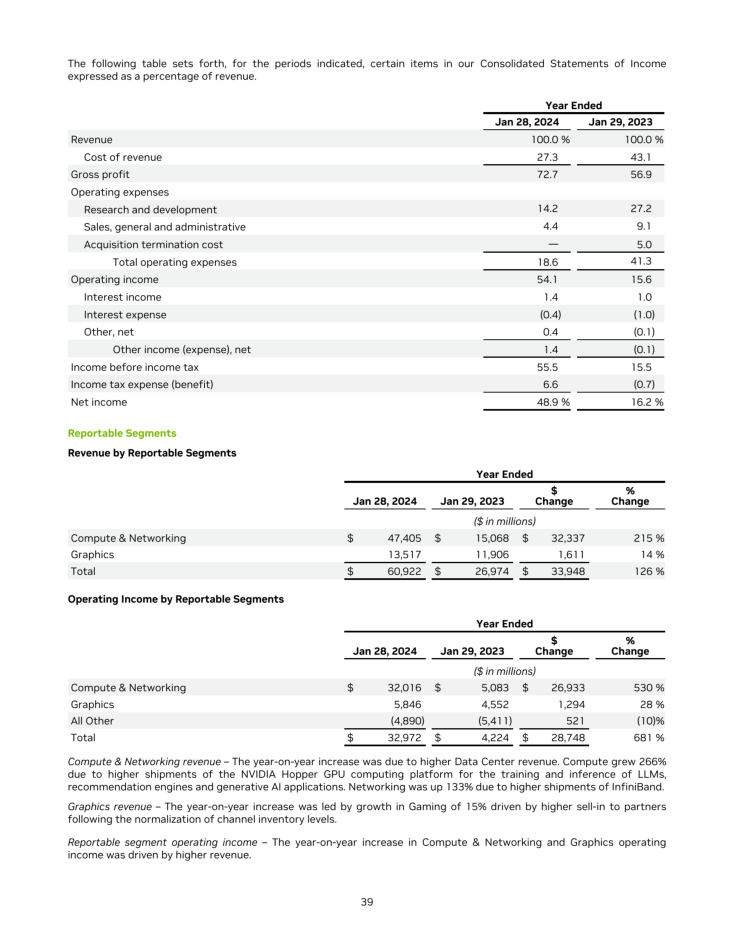

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

The following table sets forth, for the periods indicated, certain items in our Consolidated Statements of Income expressed as a percentage of revenue.

|                                   | Year Ended   | Year Ended   |
|-----------------------------------|--------------|--------------|
|                                   | Jan 28, 2024 | Jan 29, 2023 |
| Revenue                           | 100.0 %      | 100.0 %      |
| Cost of revenue                   | 27.3         | 43.1         |
| Gross profit                      | 72.7         | 56.9         |
| Operating expenses                |              |              |
| Research and development          | 14.2         | 27.2         |
| Sales, general and administrative | 4.4          | 9.1          |
| Acquisition termination cost      | -            | 5.0          |
| Total operating expenses          | 18.6         | 41.3         |
| Operating income                  | 54.1         | 15.6         |
| Interest income              

In [28]:
display_file("/kaggle/input/nvidia-annual-report/NVIDIA_Report_Removed_Pages-1-16-9.pdf")
extract_data_with_docling("/kaggle/input/nvidia-annual-report/NVIDIA_Report_Removed_Pages-1-16-9.pdf")

In [31]:
df = pd.read_csv("/kaggle/working/NVIDIA_Report_Removed_Pages-1-16-9-table-1.csv")
df = df.loc[:, ~df.columns.str.contains('^Unnamed: 0')]
df

,Unnamed: 1,"Year Ended.Jan 28, 2024","Year Ended.Jan 29, 2023"
0,Revenue,100.0 %,100.0 %
1,Cost of revenue,27.3,43.1
2,Gross profit,72.7,56.9
3,Operating expenses,NaN,NaN
4,Research and development,14.2,27.2
5,"Sales, general and administrative",4.4,9.1
6,Acquisition termination cost,-,5.0
7,Total operating expenses,18.6,41.3
8,Operating income,54.1,15.6
9,Interest income,1.4,1.0


In [32]:
df = pd.read_csv("/kaggle/working/NVIDIA_Report_Removed_Pages-1-16-9-table-2.csv")
df = df.loc[:, ~df.columns.str.contains('^Unnamed: 0')]
df

,Unnamed: 1,"Year Ended.Jan 28, 2024.($ in millions)","Year Ended.Jan 29, 2023.($ in millions)",Year Ended.$ Change.($ in millions),Year Ended.% Change.($ in millions)
0,Compute & Networking,"$ 47,405","$ 15,068","$ 32,337",215 %
1,Graphics,"13,517","11,906","1,611",14 %
2,Total,"$ 60,922","$ 26,974","$ 33,948",126 %


In [33]:
df = pd.read_csv("/kaggle/working/NVIDIA_Report_Removed_Pages-1-16-9-table-3.csv")
df = df.loc[:, ~df.columns.str.contains('^Unnamed: 0')]
df

,Unnamed: 1,"Year Ended.Jan 28, 2024.($ in millions)","Year Ended.Jan 29, 2023.($ in millions)",Year Ended.$ Change.($ in millions),Year Ended.% Change.($ in millions)
0,Compute & Networking,"$ 32,016","$ 5,083","$ 26,933",530 %
1,Graphics,"5,846","4,552","1,294",28 %
2,All Other,"(4,890)","(5,411)",521,(10)%
3,Total,"$ 32,972","$ 4,224","$ 28,748",681 %


## **4. Conclusion**   <a class="anchor"  id="chapter4"></a>

<div style="background-color: red; color: white; padding: 10px;">
<strong>Based on the results obtained from various images and PDF files, Docling has proven to be highly effective at extracting tables with remarkable accuracy. It handles even tables with unusual or complex structures well, with only occasional minor issues in character recognition. Overall, I’ve found Docling to be an excellent solution that not only saves a significant amount of time but also performs efficiently on low computational resources. This makes it a reliable tool for table extraction, meeting both my accuracy and resource constraints.</strong>
</di>
>
